# Deeper dive on qcodes doNd functionalities with a focus on arrayed sweeping benefits

In this example notebook, we want to show how the qcodes measurement can be simplified by using qcodes doNd functions. Also, we test 2-dimentional sweeping with a naive point by point sweeping over x and y axis and measure z axis values compared to sweeping over x axis and considering y axis as an array of numbers to measure z axis values. The array method can be useful in buffered data acquisitions from instruments that have buffer to write data in it (this notebook is not aiming to show how to setup buffer). Therefore, the measurement time can be enhanced significantly.

### Necessary imports

In [1]:
from qcodes import initialise_or_create_database_at
import time
import numpy as np
from qcodes.instrument.parameter import Parameter
from qcodes import load_or_create_experiment, Measurement,\
load_by_run_spec
from qcodes.utils.dataset import doNd
from qcodes.dataset.plotting import plot_dataset

### Creating a database or loading it

In [2]:
initialise_or_create_database_at('test.db')

### 1. Point by point 2D sweep over x and y

The following cell is a naive way of generating an example 2D plot and time it. This uses single sweep points for both x and y directions, so it is quit slow.

In [3]:
xvals = np.linspace(-5, 5, 51)
yvals = np.linspace(-5, 5, 51)
xx, yy = np.meshgrid(xvals, yvals, indexing='ij')
zz = np.cos(xx) * np.sin(yy)

def very_simple_2d_sweep():
    for i, x in enumerate(xvals):
        for j, y in enumerate(yvals):
            yield x, y, zz[i, j]

# configure the qcodes setup
x = Parameter('x')
y = Parameter('y')
z = Parameter('z')

exp = load_or_create_experiment('very_simple_2d_sweep', sample_name='no sample')

# set up the measurement
meas = Measurement(exp)
meas.register_parameter(x)
meas.register_parameter(y)
meas.register_parameter(z, setpoints=(x, y))
meas.write_period = 2

# and start recording
t1 = time.time()
with meas.run() as datasaver:
    for xval, yval, zval in very_simple_2d_sweep():
        datasaver.add_result(
            ('x', xval),
            ('y', yval),
            ('z', zval),
        )
        time.sleep(0.1)
t2 = time.time()
print(f'Meaurement took {t2-t1} seconds')

Starting experimental run with id: 40. 
Meaurement took 287.8640215396881 seconds


([<AxesSubplot:title={'center':'Run #40, Experiment very_simple_2d_sweep (no sample)'}, xlabel='x', ylabel='y'>],
 [<matplotlib.colorbar.Colorbar at 0x1fcbaeccbc8>])

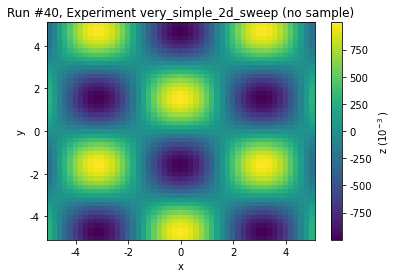

In [4]:
dataset1 = load_by_run_spec(experiment_name='very_simple_2d_sweep',\
                           captured_run_id=40)
plot_dataset(dataset1)

### 2. Sweeping over x and considering y as an array

Following cell is for producing the same plot in the above cell with a difference that it uses arrays instead of single points for y direction, which means that it is much faster than cell above.

In [5]:
xvals = np.linspace(-5, 5, 51)
yvals = np.linspace(-5, 5, 51)
xx, yy = np.meshgrid(xvals, yvals, indexing='ij')
zz = np.cos(xx) * np.sin(yy)

def simple_2d_sweep():
    for i, x in enumerate(xvals):
        yield x, yy[i, :], zz[i, :]

# configure qcodes setup
x = Parameter('x')
y = Parameter('y')
z = Parameter('z')

exp = load_or_create_experiment('simple_2d_sweep', sample_name='no sample')

# set up measurement
meas = Measurement(exp)
meas.register_parameter(x)
meas.register_parameter(y)
meas.register_parameter(z, setpoints=(x, y))
meas.write_period = 2

# start measuring
t1 = time.time()
with meas.run() as datasaver:
    for xval, yval, zval in simple_2d_sweep():
        datasaver.add_result(
            (x, xval),
            (y, yval),
            (z, zval),
        )
        time.sleep(0.1)

t2 = time.time()
print(f'Meaurement took {t2-t1} seconds')

Starting experimental run with id: 41. 
Meaurement took 5.7026965618133545 seconds


([<AxesSubplot:title={'center':'Run #41, Experiment simple_2d_sweep (no sample)'}, xlabel='x', ylabel='y'>],
 [<matplotlib.colorbar.Colorbar at 0x1fcc4071448>])

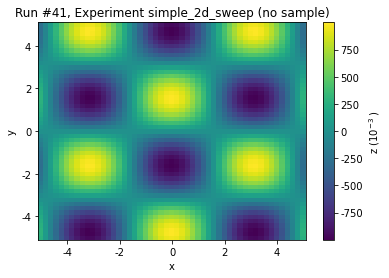

In [6]:
dataset2 = load_by_run_spec(experiment_name='simple_2d_sweep',\
                           captured_run_id=41)
plot_dataset(dataset2)

### 3. Point by point 2D sweep over x and y using qcodes do2d

Following cell is for producing the same result as the the section 1 with the differnce that it uses qcodes do2d function for
simplyfing measurement setup. 

In [7]:
def very_simple_2d_sweep_do2d():
    return np.cos(x()) * np.sin(y())

# configure the qcodes setup
x = Parameter('x', set_cmd=None)
y = Parameter('y', set_cmd=None)
z = Parameter('z', get_cmd=lambda:very_simple_2d_sweep_do2d())

exp = load_or_create_experiment('very_simple_sweep_do2d', sample_name='no sample')

t1 = time.time()
doNd.do2d(x, -5, 5, 51, 0.1, y, -5, 5, 51, 0.1, z, do_plot=False)
t2 = time.time()
print(f'Meaurement took {t2-t1} seconds')

Starting experimental run with id: 43. 
Meaurement took 293.0904493331909 seconds


([<AxesSubplot:title={'center':'Run #43, Experiment very_simple_sweep_do2d (no sample)'}, xlabel='x', ylabel='y'>],
 [<matplotlib.colorbar.Colorbar at 0x1fcc4229fc8>])

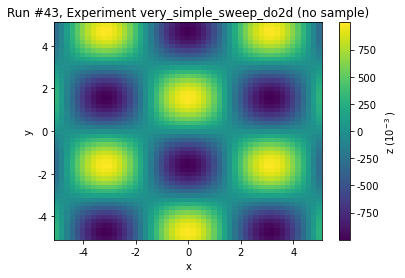

In [8]:
dataset3 = load_by_run_spec(experiment_name='very_simple_sweep_do2d',\
                           captured_run_id=43)
plot_dataset(dataset3)

## 4. Sweeping over x and considering y as an array and using qcodes do1d

This cell is for using the same approach in section 2 with the differnce that it utilizes the qcodes do1d function for simplyfing the measurement setup. So, it generates the same result as section 3 with a much faster rate.

In [9]:
def simple_2d_sweep_do1d():
    return np.cos(x()) * np.sin(y())

# configure qcodes setup
x = Parameter('x', set_cmd=None)
y = Parameter('y', get_cmd=lambda: np.linspace(-5, 5, 51))
z = Parameter('z', get_cmd=lambda: simple_2d_sweep_do1d())

exp = load_or_create_experiment('simple_sweep_do1d', sample_name='no sample')

t1 = time.time()
doNd.do1d(x, -5, 5, 51, 0.1, z, additional_setpoints = [y], do_plot=False)
t2 = time.time()
print(f'Meaurement took {t2-t1} seconds')

Starting experimental run with id: 47. 
Meaurement took 5.67435884475708 seconds


Tried to set data shape for z in dataset z from metadata when loading but found inconsistent lengths 2601 and 51
Tried to set data shape for x in dataset z from metadata when loading but found inconsistent lengths 2601 and 51
Tried to set data shape for y in dataset z from metadata when loading but found inconsistent lengths 2601 and 51


([<AxesSubplot:title={'center':'Run #47, Experiment simple_sweep_do1d (no sample)'}, xlabel='x', ylabel='y'>],
 [<matplotlib.colorbar.Colorbar at 0x1fcc42e2388>])

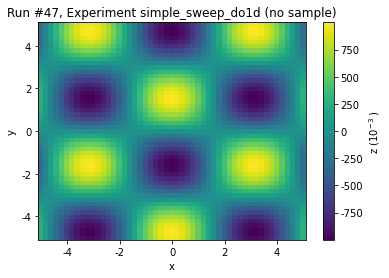

In [10]:
dataset4 = load_by_run_spec(experiment_name='simple_sweep_do1d',\
                           captured_run_id=47)
plot_dataset(dataset4)